In [ ]:
%load_ext autoreload
%autoreload 2
import os, pickle, csv, itertools, shutil, random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torchvision, torch
import scipy
# from torchvision import transforms
from omegaconf import OmegaConf as oc

%matplotlib inline
%config InlineBackend.figure_format='retina'

import utils.utils as utils
import evals.embed_evals as evals
import utils.plot_data as plot
import utils.gen_triplets as gen
import models.transforms as transforms
import algorithms.teaching_algs as algs

import warnings
warnings.filterwarnings("ignore")
from collections import defaultdict

In [152]:
z_train = pickle.load(open("data/embeds/bm_prolific/TN_train_d50_seed42.pkl","rb"))
z_valid = pickle.load(open("data/embeds/bm_prolific/TN_valid_d50_seed42.pkl","rb"))
z_test = pickle.load(open("data/embeds/bm_prolific/TN_test_d50_seed42.pkl","rb"))
img2idx_train = {path.split("/")[-1]:i for i, path in enumerate(utils.dataset_filenames("data/datasets/bm/train")[:,0])}
img2idx_valid = {path.split("/")[-1]:i for i, path in enumerate(utils.dataset_filenames("data/datasets/bm/valid")[:,0])}
img2idx_test = {path.split("/")[-1]:i for i, path in enumerate(utils.dataset_filenames("data/datasets/bm/test")[:,0])}

In [153]:
def euc_dist(x, y): return np.sqrt(np.dot(x, x) - 2 * np.dot(x, y) + np.dot(y, y))

def dist_path(path_a, path_b):
    z_a = img2z(path_a)
    z_b = img2z(path_b)
    return euc_dist(z_a, z_b)

def img2z(path):
    fold = path.split("/")[-3]
    img = path.split("/")[-1]
    if fold == "train":
        z = z_train[img2idx_train[img]]
    elif fold == "valid":
        z = z_valid[img2idx_valid[img]]
    elif fold == "test":
        z = z_test[img2idx_test[img]]
    return z

def img2c(path):
    return int(path.split("/")[-2])

def corr(x,y):
    # plt.scatter(y,x)
    # plt.show()
    return scipy.stats.pearsonr(x, y)[0]

def acc(preds):
    return preds.sum()/len(preds)
    
def quant_bars(preds, data):
    preds = np.array(preds)
    data = np.array(data)
    sorted_idx = np.argsort(data)
    n = len(data)
    bin_size = n//10
    bins = []
    for bin_start in np.arange(0, n, bin_size):
        if n-bin_start < bin_size: 
            break
        bin = sorted_idx[bin_start: bin_start+bin_size]
        bins.append(bin)
    bins = np.array(bins)
    pred_bins = preds[bins]
    m_bins = data[bins]
    m_quants = [acc(b) for b in  pred_bins]

    return m_quants

def plot_quants(m_quants, title):
    quantiles = np.arange(1,11)/10
    plt.figure(figsize=[8,6])
    plt.bar(quantiles, m_quants, width=0.06, align="center", tick_label=quantiles)
    plt.xlabel("quantiles")
    plt.ylabel("decision support acc.")
    plt.title(title)
    plt.plot()

def get_dists(df):
    dap, dan, dpn, pred_correct = [],[],[], []
    for i in range(len(df)):
        row = df.iloc[i]
        a, p, n = row["q_a"],row["q_p"],row["q_n"]
        pred_correct.append(row["pred"]==img2c(a))
        dap.append(dist_path(a,p))
        dan.append(dist_path(a,n))
        dpn.append(dist_path(p,n))
    pred_correct = np.array(pred_correct)
    dap = np.array(dap)
    dan = np.array(dan)
    dpn = np.array(dpn)
    return dap, dan, dpn, pred_correct

def plot_corr(dap, dan, dpn, pred_correct):
    titles = ["d_an/(d_ap+d_an)", "d_an/(d_ap+d_an)", "|d_ap-d_an|", "d_pn"]
    datum = [dan/(dap+dan), dap/(dap+dan), abs(dap-dan), dpn]
    for data, title in zip(datum, titles):
        m_quants = quant_bars(pred_correct, data)
        plot_quants(m_quants, title)
        print(corr(pred_correct, data))

In [182]:
qa_df = pd.read_csv("db1.qa.csv")
# splits = qa_df["split_pool"].unique()
df = qa_df[qa_df["split_pool"]=="dc0"]
# df = qa_df
print(len(df))
dap, dan, dpn, pred_correct = get_dists(df)

1320


-0.013397829924414049
0.013397829924414057
-0.025119121999759658
-0.02318733885976871


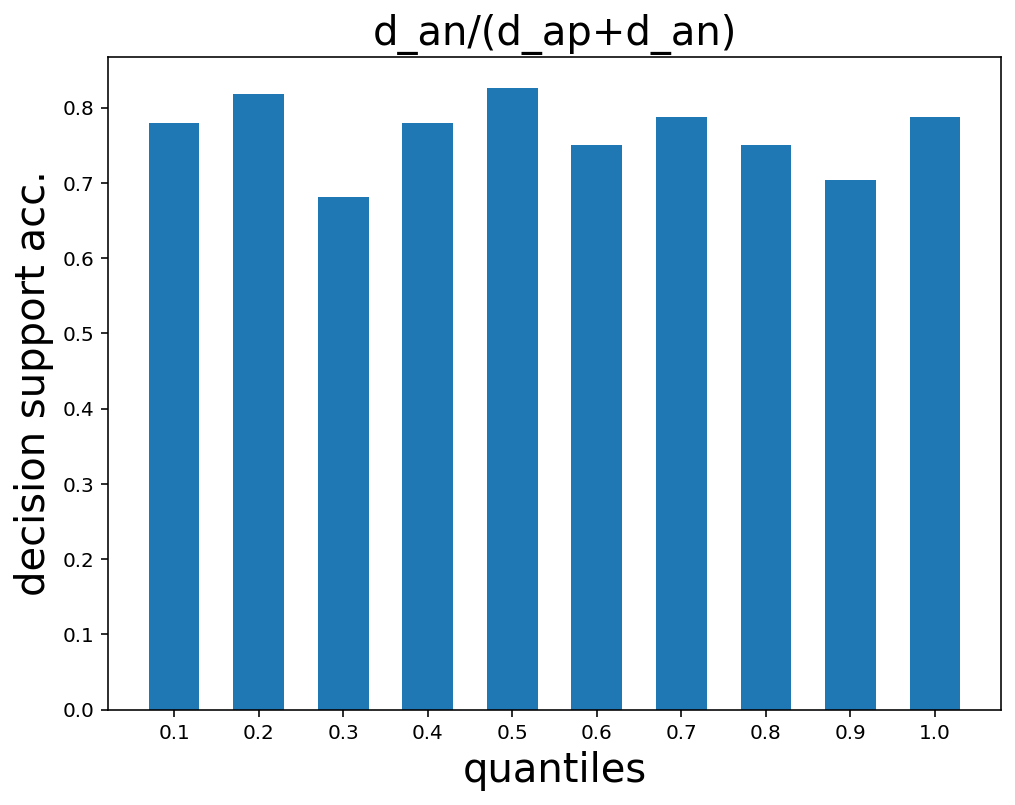

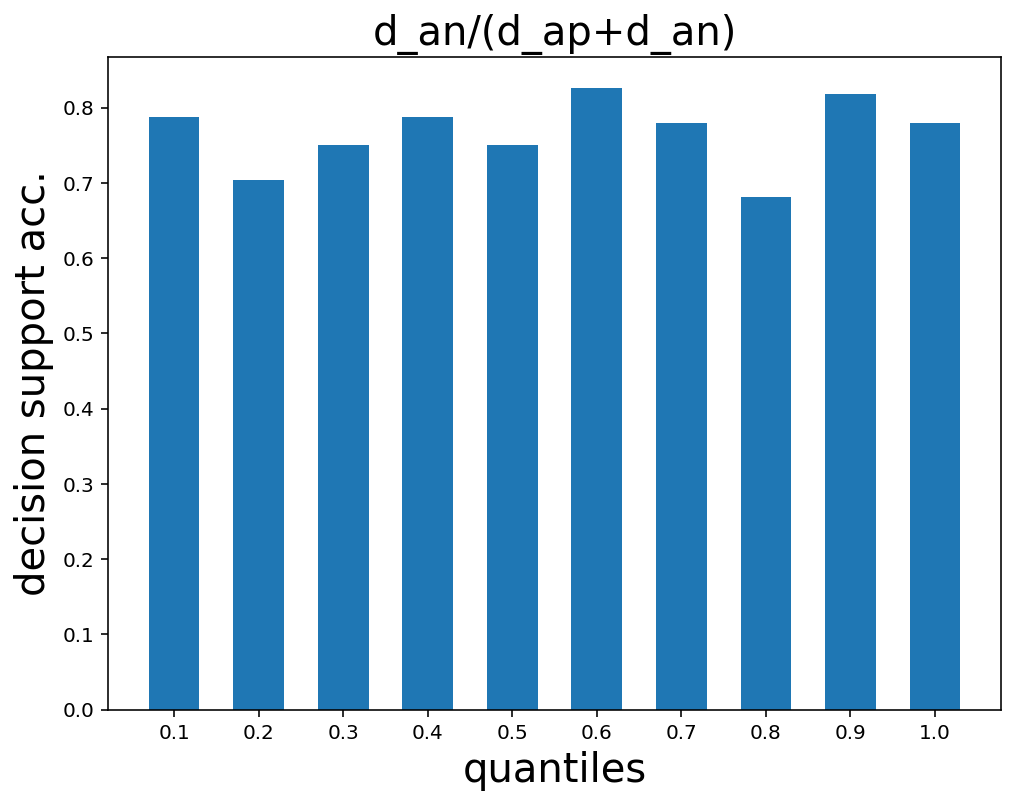

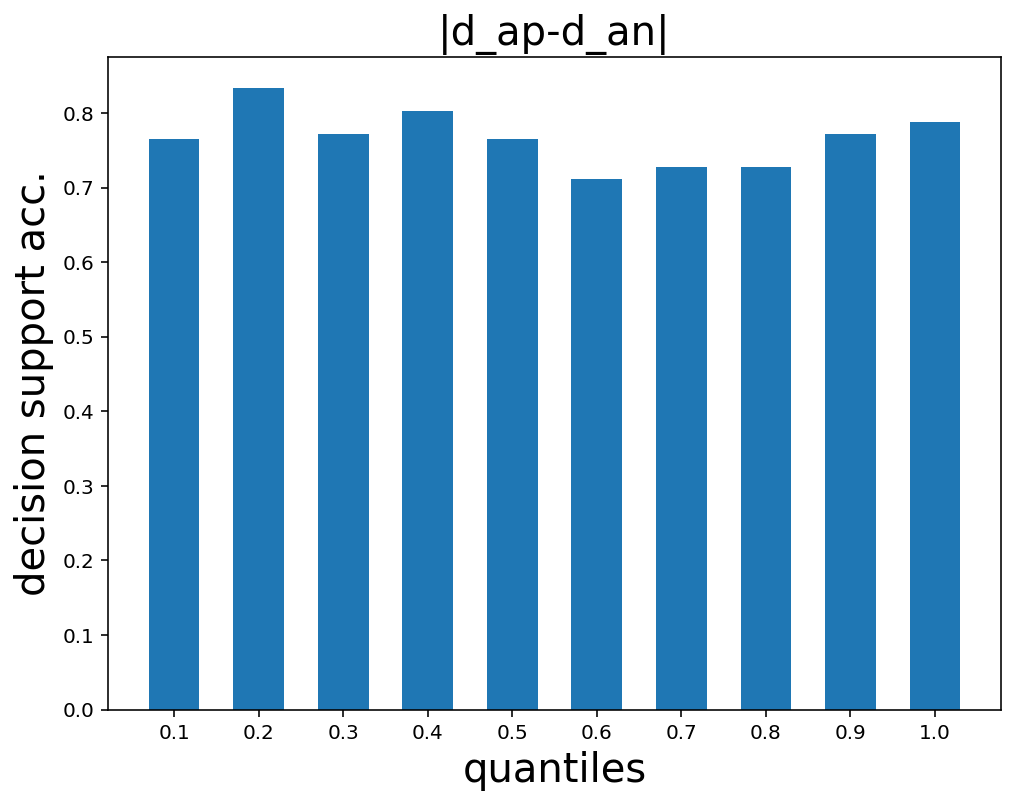

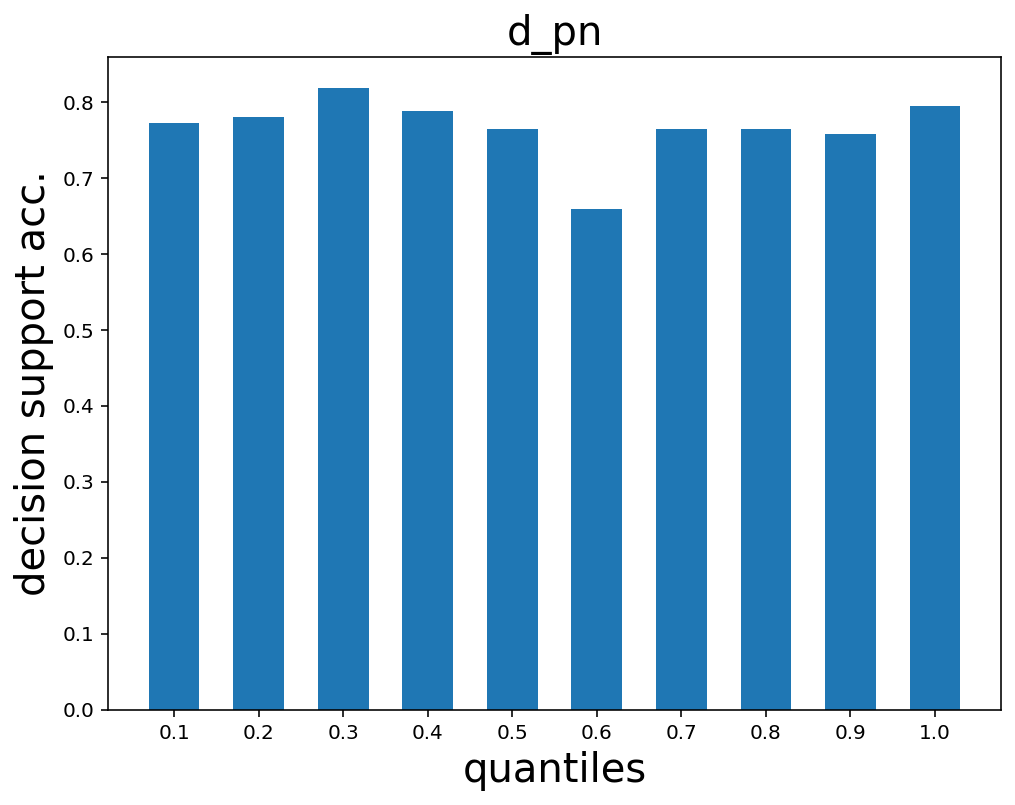

In [183]:
plot_corr(dap, dan, dpn, pred_correct)

In [157]:
z_train = pickle.load(open("data/embeds/wv/align=0.5/MTL_train_d50_seed42.pkl","rb"))
z_test = pickle.load(open("data/embeds/wv/align=0.5/MTL_test_d50_seed42.pkl","rb"))
syn_x_train = pickle.load(open("data/datasets/wv_3d_square/train_features.pkl","rb"))
syn_x_test = pickle.load(open("data/datasets/wv_3d_square/test_features.pkl","rb"))

train = torchvision.datasets.ImageFolder(f"data/datasets/wv_3d_square/train")
test = torchvision.datasets.ImageFolder(f"data/datasets/wv_3d_square/test")
y_train = np.array([x[1] for x in train])
y_test = np.array([x[1] for x in test])
y_pred = y_test

In [158]:
def get_dists_syn(x_train, y_train, x_test, y_test, examples, weights, powers):
    """ decision support acc given examples and weights to human distance """
    correct = 0
    err = []
    dap, dan, dpn, pred_correct = [],[],[], []
    m = []
    for test_idx, examples_idx in enumerate(examples):
        examples_idx = examples_idx.flatten()
        if len(np.unique(examples_idx)) < len(examples_idx): ## signal of error in rNINO
            err.append([test_idx, examples_idx[0], examples_idx[1]])
            continue
        ref = x_test[test_idx]
        
        dist_fn = lambda x, y: evals.weightedPdist(x, y, weights, powers)
        dists = [dist_fn(ref, x_train[idx]) for idx in examples_idx]
        y_pred = y_train[examples_idx[np.argmin(dists)]]
        if y_pred == y_test[test_idx]: 
            correct += 1
            pred_correct.append(1)
        else: 
            err.append([test_idx, examples_idx[0], examples_idx[1]])
            pred_correct.append(0)

        d1, d2 = dists
        d12 = dist_fn(x_train[examples_idx[0]], x_train[examples_idx[1]])
        dap.append(d1)
        dan.append(d2)
        dpn.append(d12)

    pred_correct = np.array(pred_correct)
    dap = np.array(dap).flatten()
    dan = np.array(dan).flatten()
    dpn = np.array(dpn).flatten()
    return dap, dan, dpn, pred_correct

In [159]:
weights, powers = [0,0,1,1], [2,2]

In [160]:
euc_dist_M = evals.euclidean_distances(z_test,z_train)
NINO = evals.get_NINO(euc_dist_M, y_train, y_pred, 1)
# NINO = evals.get_NIFO(euc_dist_M, y_train, y_pred, 1)
dap, dan, dpn, pred_correct = get_dists_syn(syn_x_train, y_train, syn_x_test, y_test, NINO, weights, powers)

0.8235371956263807
-0.8235371956263806
0.2756613829108475
0.17383915731371674


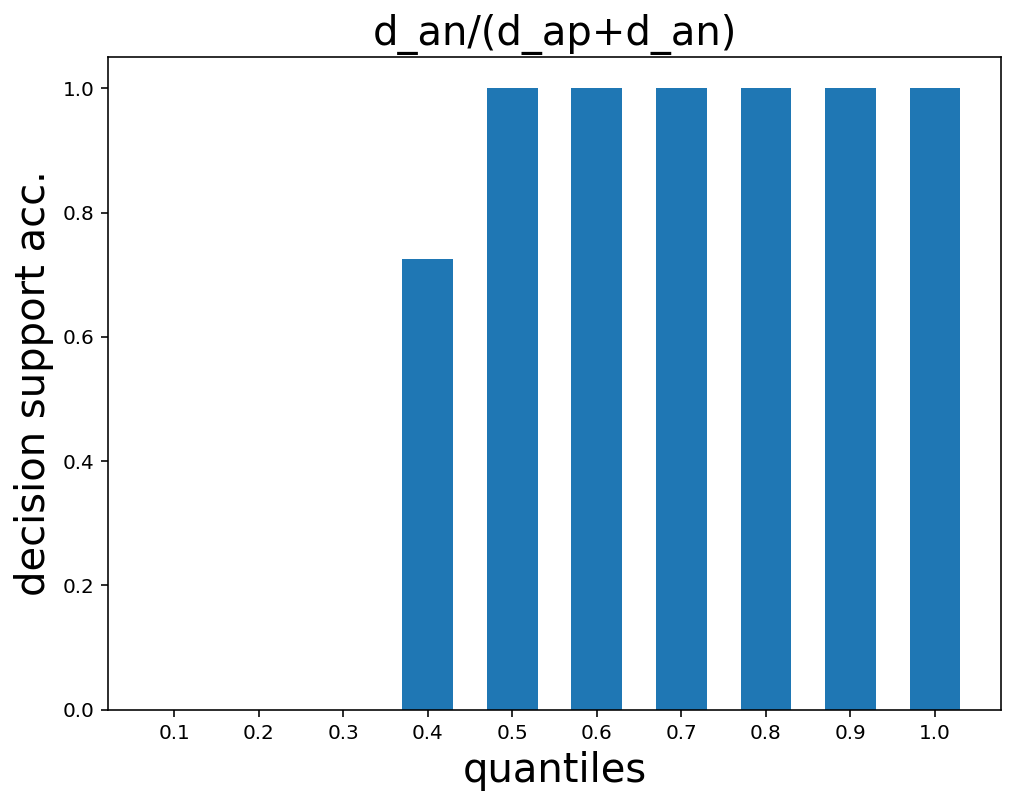

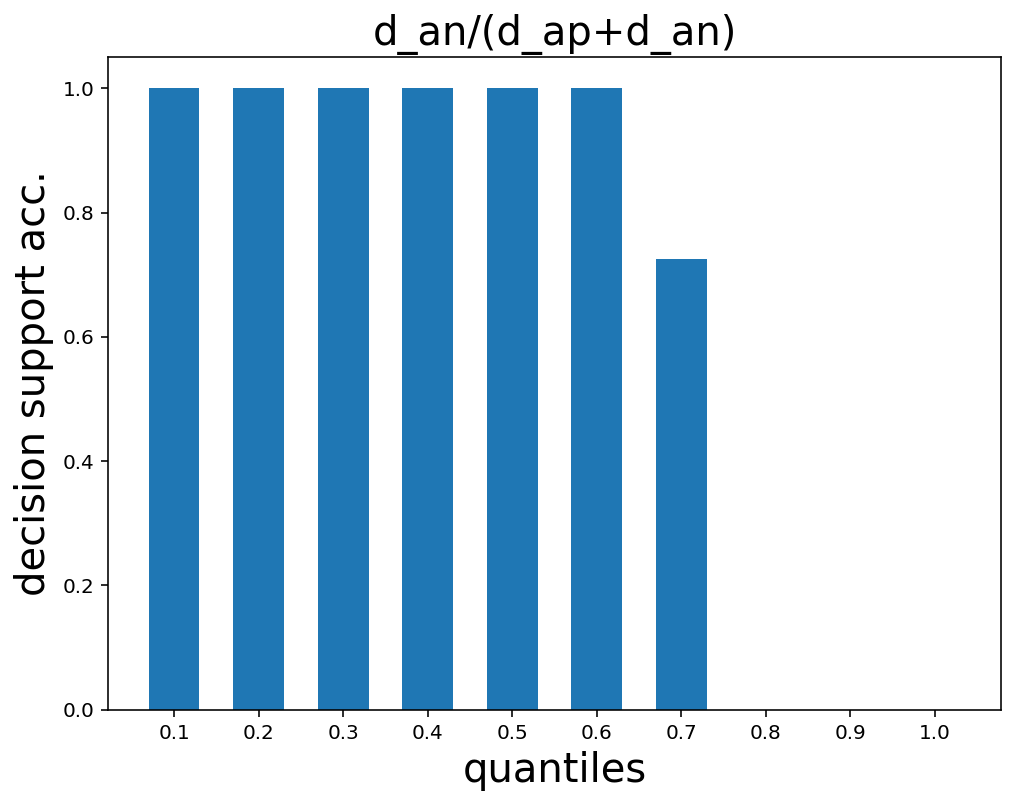

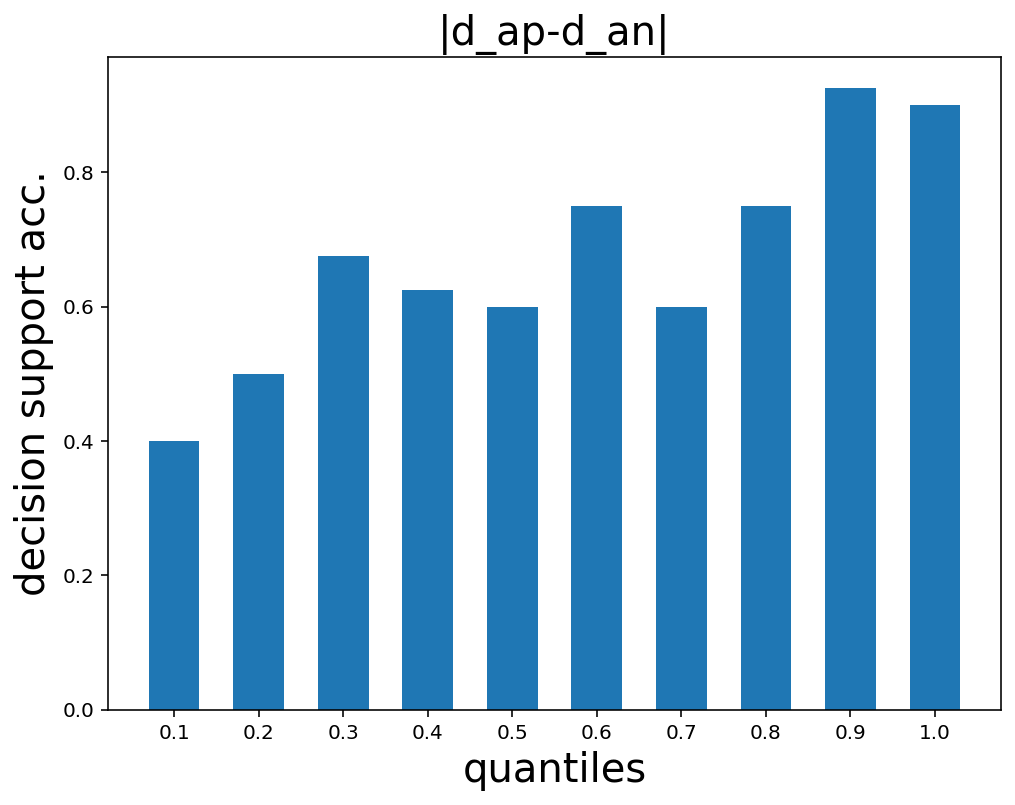

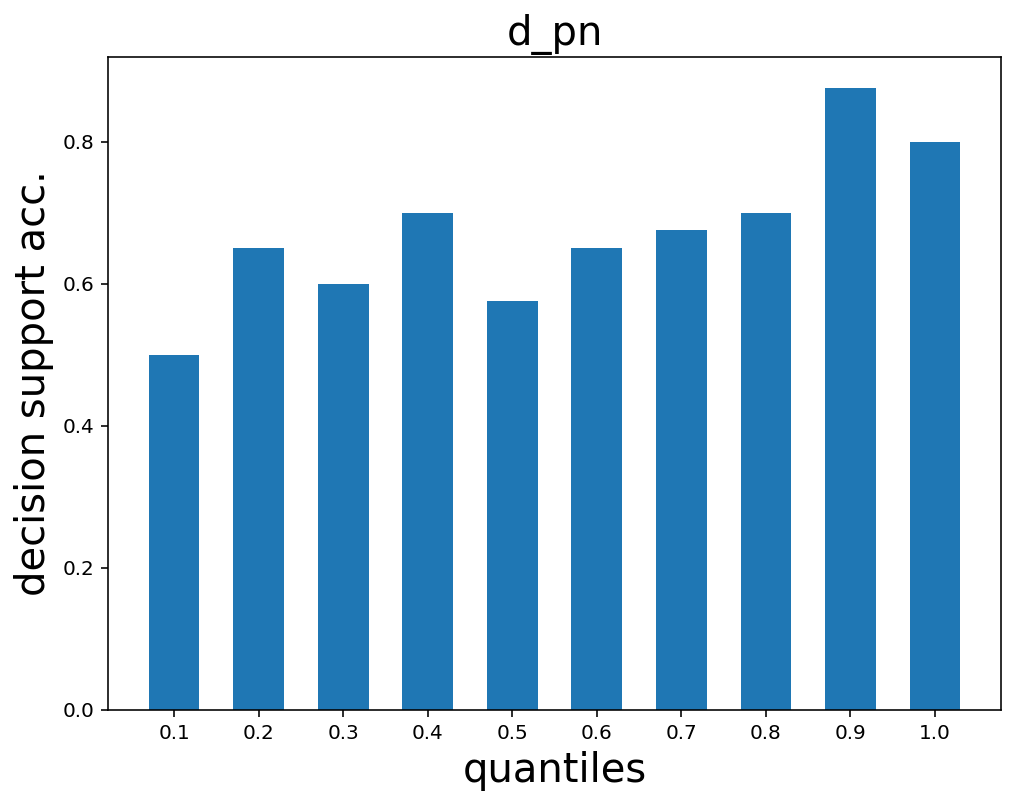

In [161]:
plot_corr(dap, dan, dpn, pred_correct)

In [ ]:
data = m[:,0]
title = "d_ap/(d_ap+d_an)"
m_quants = quant_bars(pred_correct, data)
plot_quants(m_quants, title)
corr(pred_correct, data)

In [ ]:
data = m[:,1]
title = "d_ap(d_ap+d_an)"
m_quants = quant_bars(pred_correct, data)
plot_quants(m_quants, title)
corr(pred_correct, data)

In [ ]:
data = m[:,2]
title = "|d_ap-d_an|"
m_quants = quant_bars(pred_correct, data)
plot_quants(m_quants, title)
corr(pred_correct, data)

In [ ]:
data = m[:,3]
title = "d_pn"
m_quants = quant_bars(pred_correct, data)
plot_quants(m_quants, title)
corr(pred_correct, data)

In [ ]:
SMALL_SIZE = 15
MEDIUM_SIZE = 20
BIGGER_SIZE = 35
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
color_list = ['k','y','m','g','c','r','b','lime']
marker_list = ['o','s','^','D','x','p','*','8']
linestyle_list = ['solid','dashed','dashdot','dotted','solid','dashed','dashdot','dotted']

In [ ]:
scipy.stats.pearsonr(data, preds)

In [ ]:
corr(preds, m[:,1])

In [ ]:
corr(preds, m[:,2])

In [ ]:
corr(preds, m[:,3])

In [ ]:
idx = np.random.choice(np.arange(1583),500,replace=False)
for f in class_a[idx]:
    f = f[0]
    img_name = f.split("/")[-1]
    dst = f"/net/scratch/tianh-shared/pneumonia/pneumonia_1k/0/{img_name}"
    shutil.copy(f, dst)
idx = np.random.choice(np.arange(1583),500,replace=False)
for f in class_b[idx]:
    f = f[0]
    img_name = f.split("/")[-1]
    dst = f"/net/scratch/tianh-shared/pneumonia/pneumonia_1k/1/{img_name}"
    shutil.copy(f, dst)

In [ ]:
algs.protodash(X, 10)

In [ ]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.decomposition import PCA

In [ ]:
pca_dims = PCA()
pca_dims.fit(X_flat)
cumsum = np.cumsum(pca_dims.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1

In [ ]:
pca = PCA(n_components=120).fit_transform(X_flat)
X_reduced = pca.fit_transform(X_flat)
X_recovered = pca.inverse_transform(X_reduced)

In [ ]:
X_recovered.shape


In [ ]:
X_reduced.shape

In [ ]:
plt.imshow(dataset[0][0].reshape((32,32,3)))


In [ ]:
f = plt.figure()
f.add_subplot(1,2, 1)
plt.title("original")
plt.imshow(X_flat[0].reshape((224,224,3)))
f.add_subplot(1,2, 2)

plt.title("PCA compressed")
plt.imshow(X_reduced[0].reshape((120,120,3 )))
# plt.show(block=True)

In [ ]:
# remove non-triplets in qa.csv
k = 0
i = 0
while True:
    if k == len(qa_df) or i >= len(qa_df)-3:
        break
    else:
        k += 1
    q_id = qa_df["question_id"]
    for i in np.arange(0,len(q_id),3):
        if i >= len(qa_df)-3: 
            break
        idx = q_id.index[i]
        if q_id.loc[idx] != q_id.loc[idx+1] or q_id.loc[idx] != q_id.loc[idx+2] or q_id.loc[idx+1] != q_id.loc[idx+2]:
            qa_df = qa_df.drop(index=[idx,idx+1])
            # print("?")
            # print(q_id.loc[idx:idx+6])
            break